
# Project: Investigate Soccer Database

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> This soccer database comes from Kaggle and is well suited for data analysis and machine learning. It contains data for soccer matches, players, and teams from several European countries from 2008 to 2016. This dataset is quite extensive, and we encourage you to read more about it [here](https://www.kaggle.com/hugomathien/soccer).

Research questions:
* What teams improved the most over the time period?
* What is the best player in penalties?
* Which factors lead to the most victories?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

> **Tip**: In this section of the report, we will load in the data, check for cleanliness, and then trim and clean the dataset for analysis.

### General Properties

In [2]:
# connecting to the database through sqlite
con = sqlite3.connect("database.sqlite")
# This query gets the Country table
df_country = pd.read_sql_query("SELECT * from Country", con)
df_country

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy
5,13274,Netherlands
6,15722,Poland
7,17642,Portugal
8,19694,Scotland
9,21518,Spain


In [3]:
# This query gets the League table joined with the Counrty table
league_query = 'SELECT L.id, C.name, L.name from League L JOIN Country C ON C.id = L.country_id'
df_league = pd.read_sql_query(league_query, con)
df_league

,id,name,name
0,1,Belgium,Belgium Jupiler League
1,1729,England,England Premier League
2,4769,France,France Ligue 1
3,7809,Germany,Germany 1. Bundesliga
4,10257,Italy,Italy Serie A
5,13274,Netherlands,Netherlands Eredivisie
6,15722,Poland,Poland Ekstraklasa
7,17642,Portugal,Portugal Liga ZON Sagres
8,19694,Scotland,Scotland Premier League
9,21518,Spain,Spain LIGA BBVA


In [4]:
# This query gets the Match tabel joined with the Country table, the League table and the Team table.
match_query = """SELECT M.id, 
                        C.name AS country_name, 
                        L.name AS league_name, 
                        season, 
                        stage, 
                        date,
                        HT.team_long_name AS  home_team,
                        AT.team_long_name AS away_team,
                        home_team_goal, 
                        away_team_goal                                        
                    FROM Match M
                    JOIN Country C on C.id = M.country_id
                    JOIN League L on L.id = M.league_id
                    LEFT JOIN Team AS HT on HT.team_api_id = M.home_team_api_id
                    LEFT JOIN Team AS AT on AT.team_api_id = M.away_team_api_id
                    ORDER by date
                    """
df_match = pd.read_sql_query(match_query, con)
df_match.head()

,id,country_name,league_name,season,stage,date,home_team,away_team,home_team_goal,away_team_goal
0,24559,Switzerland,Switzerland Super League,2008/2009,1,2008-07-18 00:00:00,BSC Young Boys,FC Basel,1,2
1,24560,Switzerland,Switzerland Super League,2008/2009,1,2008-07-19 00:00:00,FC Aarau,FC Sion,3,1
2,24561,Switzerland,Switzerland Super League,2008/2009,1,2008-07-20 00:00:00,FC Luzern,FC Vaduz,1,2
3,24562,Switzerland,Switzerland Super League,2008/2009,1,2008-07-20 00:00:00,Neuchâtel Xamax,FC Zürich,1,2
4,24613,Switzerland,Switzerland Super League,2008/2009,2,2008-07-23 00:00:00,FC Basel,Grasshopper Club Zürich,1,0


In [5]:
# This query gets the Player table joined with the Player_Attributes table
player_query = 'SELECT * from Player P JOIN Player_Attributes PA ON PA.player_api_id = P.player_api_id'
df_player = pd.read_sql_query(player_query, con)
df_player.head()

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight,id,player_fifa_api_id,player_api_id,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,1,218353,505942,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,2,218353,505942,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,3,218353,505942,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,4,218353,505942,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,5,218353,505942,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [6]:
# This query gets the Team table joined with the Team_Attributes table
teams_query=""" SELECT DISTINCT T.team_long_name team,
                                TA.date date,
                                TA.buildUpPlaySpeed,
                                TA.buildUpPlayDribbling,
                                TA.buildUpPlayDribblingClass,
                                TA.buildUpPlayPassing,
                                TA.chanceCreationPassing,
                                TA.chanceCreationCrossing,
                                TA.chanceCreationShooting,
                                TA.defencePressure,
                                TA.defenceAggression,
                                TA.defenceTeamWidth
                from Team T
                   join Team_Attributes TA on TA.team_api_id = T.team_api_id
                """

df_team = pd.read_sql_query(teams_query, con)
df_team.head()

,team,date,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
0,FC Aarau,2010-02-22 00:00:00,60,NaN,Little,50,60,65,55,50,55,45
1,FC Aarau,2014-09-19 00:00:00,52,48.0,Normal,56,54,63,64,47,44,54
2,FC Aarau,2015-09-10 00:00:00,47,41.0,Normal,54,54,63,64,47,44,54
3,Aberdeen,2010-02-22 00:00:00,70,NaN,Little,70,70,70,70,60,70,70
4,Aberdeen,2011-02-22 00:00:00,47,NaN,Little,52,53,48,52,47,47,52


In [7]:
# Closing the database connection
con.close()

### Data Cleaning (Replacing the missing values)

In [8]:
df_match.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              25979 non-null  int64 
 1   country_name    25979 non-null  object
 2   league_name     25979 non-null  object
 3   season          25979 non-null  object
 4   stage           25979 non-null  int64 
 5   date            25979 non-null  object
 6   home_team       25979 non-null  object
 7   away_team       25979 non-null  object
 8   home_team_goal  25979 non-null  int64 
 9   away_team_goal  25979 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 2.0+ MB


In [9]:
df_team.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1450 entries, 0 to 1449
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   team                       1450 non-null   object 
 1   date                       1450 non-null   object 
 2   buildUpPlaySpeed           1450 non-null   int64  
 3   buildUpPlayDribbling       486 non-null    float64
 4   buildUpPlayDribblingClass  1450 non-null   object 
 5   buildUpPlayPassing         1450 non-null   int64  
 6   chanceCreationPassing      1450 non-null   int64  
 7   chanceCreationCrossing     1450 non-null   int64  
 8   chanceCreationShooting     1450 non-null   int64  
 9   defencePressure            1450 non-null   int64  
 10  defenceAggression          1450 non-null   int64  
 11  defenceTeamWidth           1450 non-null   int64  
dtypes: float64(1), int64(8), object(3)
memory usage: 136.1+ KB


In [10]:
df_team.head()

,team,date,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
0,FC Aarau,2010-02-22 00:00:00,60,NaN,Little,50,60,65,55,50,55,45
1,FC Aarau,2014-09-19 00:00:00,52,48.0,Normal,56,54,63,64,47,44,54
2,FC Aarau,2015-09-10 00:00:00,47,41.0,Normal,54,54,63,64,47,44,54
3,Aberdeen,2010-02-22 00:00:00,70,NaN,Little,70,70,70,70,60,70,70
4,Aberdeen,2011-02-22 00:00:00,47,NaN,Little,52,53,48,52,47,47,52


In [11]:
# getting the unique values in the buildUpPlayDribblingClass Column
df_team.buildUpPlayDribblingClass.unique()

array(['Little', 'Normal', 'Lots'], dtype=object)

In [12]:
# calculating how many missing values in the buildUpPlayDribbling Column 
# if the value of the buildUpPlayDribblingClass is equal to 'Little'
t = df_team[df_team.buildUpPlayDribblingClass == 'Little']
t.buildUpPlayDribbling.isnull().sum()

964

> From above, we can infer that all the null values in the buildUpDribbling column are associated with the buildUpPlayDribblingClass to have a value of Little.

> One possible solution is to replace the missing values with the mean of buildUpDribbling column where the buildUpPlayDribblingClass equals Little.

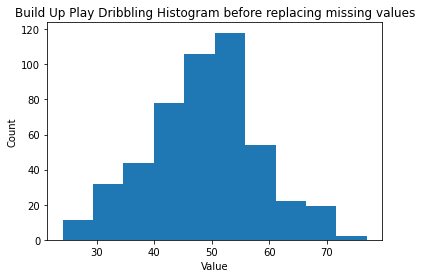

In [13]:
plt.hist(df_team.buildUpPlayDribbling)
plt.title('Build Up Play Dribbling Histogram before replacing missing values')
plt.xlabel('Value')
plt.ylabel('Count');

In [14]:
# replacing the missing values with the mean of buildUpDribbling column 
# where the buildUpPlayDribblingClass equals Little.
min_val = df_team.query('buildUpPlayDribblingClass == "Little"').buildUpPlayDribbling.mean()
print(min_val)
df_team.buildUpPlayDribbling.fillna(min_val, inplace=True)

30.485714285714284


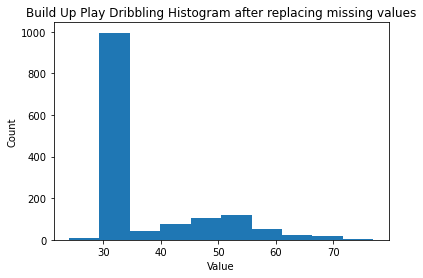

In [15]:
plt.hist(df_team.buildUpPlayDribbling);
plt.title('Build Up Play Dribbling Histogram after replacing missing values')
plt.xlabel('Value')
plt.ylabel('Count');

> From the two histograms above, we can see that the distribution of the buildUpPlayDribbiling column is no longer a normal distribution after replacing the missing values and this can be consider as a limitation.

<a id='eda'></a>
## Exploratory Data Analysis

### Research Question 1: What teams improved the most over the time period?

> My approach is to get the difference between the oldest measure of the team attributes and the latest one as a measure of improvement over this period. 

In [16]:
df_team_latest = df_team.sort_values(by='date', ascending=False).drop_duplicates(subset=['team'])
df_team_latest.shape

(285, 12)

In [17]:
df_team_latest.sort_values(by='team', inplace=True)
df_team_latest.reset_index(drop=True, inplace= True)
df_team_latest.head()

,team,date,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
0,1. FC Kaiserslautern,2015-09-10 00:00:00,49,54.0,Normal,52,49,54,64,41,51,53
1,1. FC Köln,2015-09-10 00:00:00,59,47.0,Normal,65,57,36,71,42,56,51
2,1. FC Nürnberg,2015-09-10 00:00:00,46,58.0,Normal,49,51,52,59,30,40,44
3,1. FSV Mainz 05,2015-09-10 00:00:00,60,43.0,Normal,53,49,40,44,55,62,47
4,AC Ajaccio,2015-09-10 00:00:00,59,57.0,Normal,52,48,38,52,38,47,53


In [18]:
df_team_oldest = df_team.sort_values(by='date', ascending=True).drop_duplicates(subset=['team'])
df_team_latest.shape

(285, 12)

In [19]:
df_team_oldest.sort_values(by='team', inplace=True)
df_team_oldest.reset_index(drop=True, inplace=True)
df_team_oldest.head()

,team,date,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
0,1. FC Kaiserslautern,2010-02-22 00:00:00,45,30.485714,Little,55,45,70,70,70,70,70
1,1. FC Köln,2010-02-22 00:00:00,55,30.485714,Little,65,65,40,60,45,55,70
2,1. FC Nürnberg,2010-02-22 00:00:00,45,30.485714,Little,50,40,70,70,55,55,40
3,1. FSV Mainz 05,2010-02-22 00:00:00,45,30.485714,Little,40,45,70,70,50,70,50
4,AC Ajaccio,2010-02-22 00:00:00,60,30.485714,Little,40,45,35,55,30,70,30


In [20]:
columns = ['buildUpPlaySpeed', 'buildUpPlayDribbling',
       'buildUpPlayPassing', 'chanceCreationPassing', 'chanceCreationCrossing',
       'chanceCreationShooting', 'defencePressure', 'defenceAggression',
       'defenceTeamWidth']

In [21]:
df_improvement = df_team_latest.copy()

In [22]:
for col in columns:
    df_improvement[col] = df_team_latest[col] - df_team_oldest[col]
df_improvement.head()

,team,date,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
0,1. FC Kaiserslautern,2015-09-10 00:00:00,4,23.514286,Normal,-3,4,-16,-6,-29,-19,-17
1,1. FC Köln,2015-09-10 00:00:00,4,16.514286,Normal,0,-8,-4,11,-3,1,-19
2,1. FC Nürnberg,2015-09-10 00:00:00,1,27.514286,Normal,-1,11,-18,-11,-25,-15,4
3,1. FSV Mainz 05,2015-09-10 00:00:00,15,12.514286,Normal,13,4,-30,-26,5,-8,-3
4,AC Ajaccio,2015-09-10 00:00:00,-1,26.514286,Normal,12,3,3,-3,8,-23,23


> The following histograms show the top five teams that improved the most in each of team attributes.

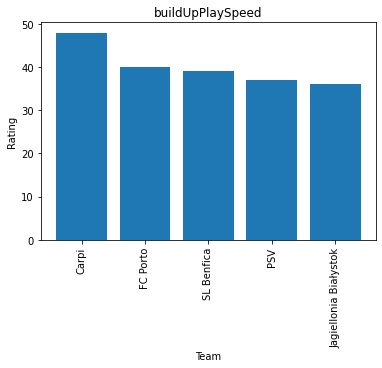

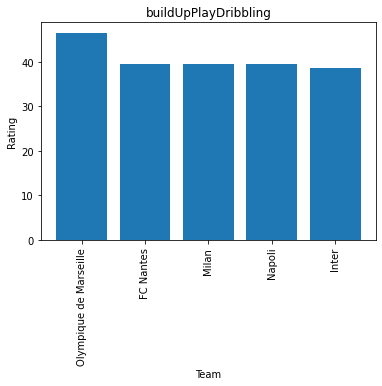

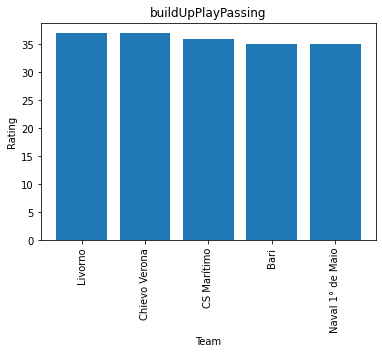

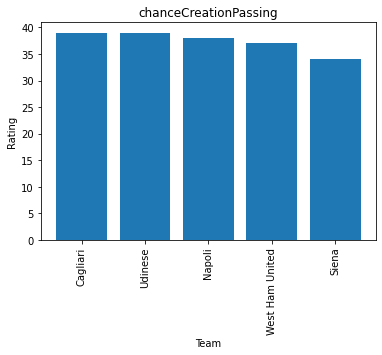

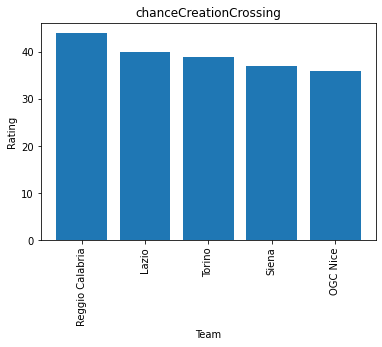

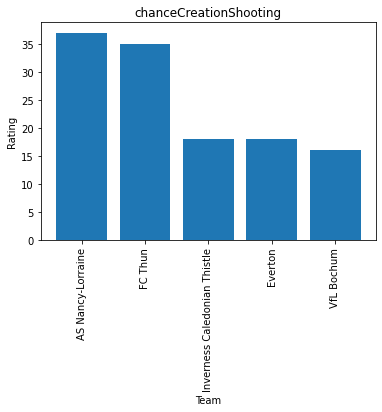

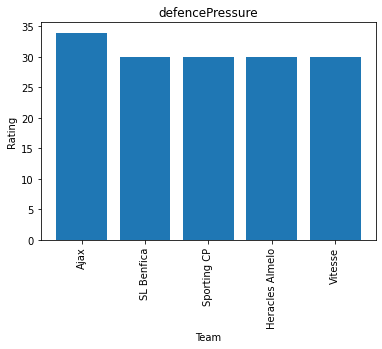

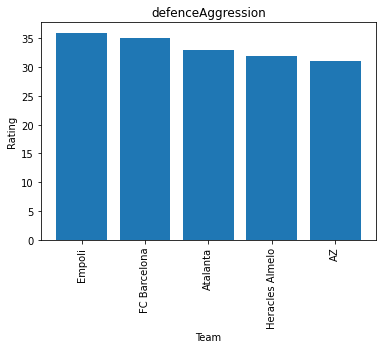

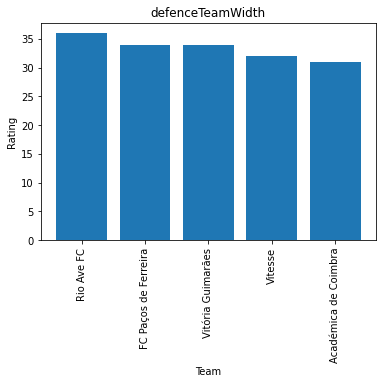

In [23]:
i = 1
for col in columns:
    df_top_5 = df_improvement.sort_values(by=col, ascending=False).head()
    plt.figure(i)
    plt.title(col)
    plt.xticks(rotation='vertical')
    i += 1
    plt.bar(df_top_5['team'], df_top_5[col])
    plt.xlabel('Team')
    plt.ylabel('Rating')

In [24]:
df_improvement['total'] = 0
for col in columns:
    df_improvement['total'] = df_improvement['total'] + df_improvement[col] 
df_improvement.head()

,team,date,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,total
0,1. FC Kaiserslautern,2015-09-10 00:00:00,4,23.514286,Normal,-3,4,-16,-6,-29,-19,-17,-58.485714
1,1. FC Köln,2015-09-10 00:00:00,4,16.514286,Normal,0,-8,-4,11,-3,1,-19,-1.485714
2,1. FC Nürnberg,2015-09-10 00:00:00,1,27.514286,Normal,-1,11,-18,-11,-25,-15,4,-26.485714
3,1. FSV Mainz 05,2015-09-10 00:00:00,15,12.514286,Normal,13,4,-30,-26,5,-8,-3,-17.485714
4,AC Ajaccio,2015-09-10 00:00:00,-1,26.514286,Normal,12,3,3,-3,8,-23,23,48.514286


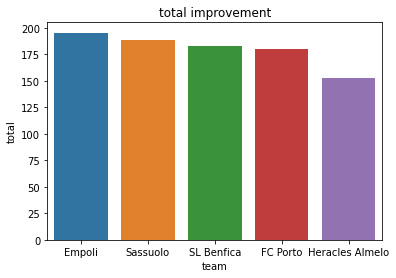

In [25]:
df_top_5 = df_improvement.sort_values(by='total', ascending=False).head()
plt.title('total improvement')
sns.barplot(data= df_top_5, x= 'team', y='total');

### Research Question 2: What is the best player in penalties?

> From the above histogram, we can see that the team called **Emploli** is the team that improved the most in the net of the team attributes over the time period.

> My approach is simply to sort the rows of the table on the penalties attribute.

In [26]:
df_player.head()

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight,id,player_fifa_api_id,player_api_id,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,1,218353,505942,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,2,218353,505942,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,3,218353,505942,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,4,218353,505942,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,5,218353,505942,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [27]:
df_player.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 49 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   183978 non-null  int64  
 1   player_api_id        183978 non-null  int64  
 2   player_name          183978 non-null  object 
 3   player_fifa_api_id   183978 non-null  int64  
 4   birthday             183978 non-null  object 
 5   height               183978 non-null  float64
 6   weight               183978 non-null  int64  
 7   id                   183978 non-null  int64  
 8   player_fifa_api_id   183978 non-null  int64  
 9   player_api_id        183978 non-null  int64  
 10  date                 183978 non-null  object 
 11  overall_rating       183142 non-null  float64
 12  potential            183142 non-null  float64
 13  preferred_foot       183142 non-null  object 
 14  attacking_work_rate  180748 non-null  object 
 15  defensive_work_ra

> We can see that there are some missing values in the penalties column, but we are only interested in the largest values, so replacing them with the mean will not make a difference. Therefore, we can drop the missing values or leave them in the dataframe.

In [28]:
df_most_penalties = df_player.sort_values(by=['penalties', 'date'], ascending=False).head()
df_most_penalties[['player_name', 'date', 'penalties']]

,player_name,date,penalties
149591,Rickie Lambert,2016-03-10 00:00:00,96.0
149592,Rickie Lambert,2015-12-24 00:00:00,96.0
149593,Rickie Lambert,2015-10-23 00:00:00,96.0
149594,Rickie Lambert,2015-09-21 00:00:00,96.0
149595,Rickie Lambert,2015-02-27 00:00:00,95.0


> We can see that Rickie Lambert had the largest measure in the penalties attribute overall.

### Research Question 3: Which factors lead to the most victories?

### Home Team vs Away Team 

In [29]:
df_match_home = df_match.query('home_team_goal > away_team_goal')
df_match_home.shape

(11917, 10)

In [30]:
df_match_away = df_match.query('home_team_goal < away_team_goal')
df_match_away.shape

(7466, 10)

In [31]:
df_match_draw = df_match.query('home_team_goal == away_team_goal')
df_match_draw.shape

(6596, 10)

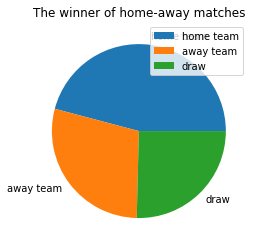

In [32]:
labels = ['home team', 'away team', 'draw']
count = [df_match_home.shape[0], df_match_away.shape[0], df_match_draw.shape[0]]
plt.pie(count, labels=labels)
plt.legend()
plt.title('The winner of home-away matches');

> From the above figure, we can deduce that the teams are more likely to win the match when they are the home team.

### Team attributes

> In the following cells, I am trying to find a correlation between the number of wins and the team attribues.


> First, I will compute the total wins over the time period for each team, then I will calculate the average of each team attribute for each team over the time period.
> Finally, I will try to visualize the relation between each team attribute and the wins count in order to see if there is a correlation or not. 

In [33]:
df_match.shape

(25979, 10)

In [34]:
df_match_not_draw = df_match.query('home_team_goal != away_team_goal')
df_match_not_draw.shape

(19383, 10)

In [35]:
def winner(df_match_not_draw):
    if df_match_not_draw['home_team_goal'] > df_match_not_draw['away_team_goal']:
        return df_match_not_draw.home_team
    return df_match_not_draw.away_team

In [36]:
df_match_not_draw['winner'] = df_match_not_draw.apply(winner, axis= 1)

<ipython-input-36-f6177845b0b9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_match_not_draw['winner'] = df_match_not_draw.apply(winner, axis= 1)


In [37]:
df_match_not_draw.head()

,id,country_name,league_name,season,stage,date,home_team,away_team,home_team_goal,away_team_goal,winner
0,24559,Switzerland,Switzerland Super League,2008/2009,1,2008-07-18 00:00:00,BSC Young Boys,FC Basel,1,2,FC Basel
1,24560,Switzerland,Switzerland Super League,2008/2009,1,2008-07-19 00:00:00,FC Aarau,FC Sion,3,1,FC Aarau
2,24561,Switzerland,Switzerland Super League,2008/2009,1,2008-07-20 00:00:00,FC Luzern,FC Vaduz,1,2,FC Vaduz
3,24562,Switzerland,Switzerland Super League,2008/2009,1,2008-07-20 00:00:00,Neuchâtel Xamax,FC Zürich,1,2,FC Zürich
4,24613,Switzerland,Switzerland Super League,2008/2009,2,2008-07-23 00:00:00,FC Basel,Grasshopper Club Zürich,1,0,FC Basel


In [38]:
df_match_winners = df_match_not_draw.groupby('winner').size()
df_match_winners.head()

winner
1. FC Kaiserslautern    17
1. FC Köln              60
1. FC Nürnberg          49
1. FSV Mainz 05         88
AC Ajaccio              22
dtype: int64

In [39]:
df_team_mean_attr = df_team.groupby('team').mean()
df_team_mean_attr.head()

,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
team,,,,,,,,,
1. FC Kaiserslautern,51.166667,37.323810,51.666667,47.166667,62.000000,59.666667,46.833333,52.833333,55.166667
1. FC Köln,57.333333,36.990476,61.166667,55.166667,41.666667,59.000000,45.000000,51.166667,60.833333
1. FC Nürnberg,45.333333,40.323810,47.500000,50.500000,53.000000,59.166667,43.333333,50.500000,44.000000
1. FSV Mainz 05,61.833333,36.490476,51.500000,53.000000,47.666667,54.500000,52.500000,62.500000,49.666667
AC Ajaccio,60.166667,39.323810,48.833333,50.333333,40.666667,52.166667,37.833333,50.500000,48.666667


In [40]:
result = pd.merge(df_match_winners.rename('wins'), df_team_mean_attr, left_index= True, right_index= True)

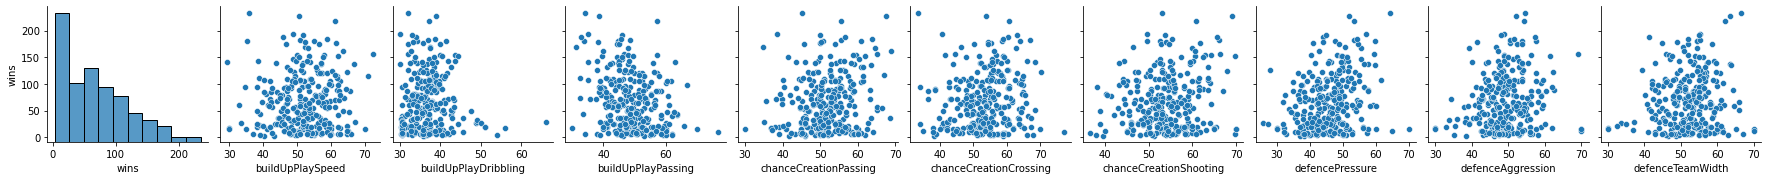

In [41]:
sns.pairplot(result, y_vars='wins');

> From the above figure, there is no clear correlation between any of the team attributes and the wins count.

<a id='conclusions'></a>
## Conclusions

* First, we showed the most improved team according to their team attributes over the time period.
* Second, we used the data to find the best player in penalties.
* Finally, we tries to find which factors decide the winning team.

Some Challanges and limitations:
* Dealing with sqlite files.
* Missing data in many columns.
* The distribution of buildUpPlayDribbling column is not normal.
* There are many tables, and in order to use these tables, I had to merge some tables with others.
* I could not find a clear correlation between the team attributes and the number of wins.